In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import torch.autograd as ag
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
from scipy import signal
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable
import time
from functools import reduce

torch.set_printoptions(precision=6)


0 torch.Size([20, 1, 128, 128])
1 torch.Size([20, 1, 128, 128])
2 torch.Size([20, 1, 128, 128])


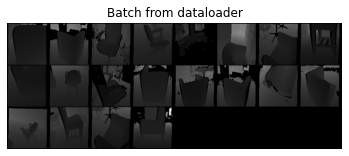

"\ntransform = transforms.Compose([\n    transforms.Pad(12, padding_mode='reflect'),\n    transforms.ToTensor()])\n\ntrainset = torchvision.datasets.Flickr8k(root='./data/flickr', ann_file = './data/flickr/file.csv', transform=transform)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)\n"

In [2]:
class ImageDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        path, dirs, files = next(os.walk(self.root_dir))
        file_count = len(files)
        return file_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path, dirs, files = next(os.walk(self.root_dir))
        img_name = os.path.join(self.root_dir, files[idx])
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image


class RandomCrop(object):
    """Crop randomly the image

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        if h!= new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top = 0
        if w!= new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
     
        image = image[top: top + new_h,
                      left: left + new_w]
        
        image = np.expand_dims(image, axis=2)

        return image
    
    
class Downsample(object):
    """Downsample the image

    Args:
        downsampling_factor (int or tuple): Desired downsampling factor for rows and columns.
        If the downsampling factor is an int, then both rows and columns are sampled by the same factor
    """

    def __init__(self, downsampling_factor):
        assert isinstance(downsampling_factor, (int, tuple))
        if isinstance(downsampling_factor, int):
            self.downsampling_factor = (downsampling_factor, downsampling_factor)
        else:
            assert len(downsampling_factor) == 2
            self.downsampling_factor = downsampling_factor

    def __call__(self, image):
        
        down_fact_h, down_fact_w = self.downsampling_factor
        image = image[::down_fact_h,
                      ::down_fact_w]

        return image
    
    
class ConvertDepthToColor(object):
    """ convert a 1xmxn 16-bits depthmap to a 2xmxn 8-bits colormap

    """

    def __call__(self, image):
        if len(image.shape[:]) <3:
            image = np.expand_dims(image, axis=2)
            
        h, w = image.shape[:2]
        image_r_color= np.zeros((h,w,1), dtype=int)
        image_g_color= np.zeros((h,w,1), dtype=int)
        image_g_color[(image > 2**8 - 1)] = image[(image > 2**8 - 1)] >> 8
        image_r_color = image - (image_g_color <<8)

        return np.concatenate((image_r_color, image_g_color), axis=2)
    

class ToTensor(object):
    """Convert ndarrays in images to Tensors."""

    def __call__(self, images):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        images = images.transpose((2, 0, 1))
        images = images.astype(float)
        return torch.from_numpy(images)
    

    
class ConvertColorToDepth(object):
    """ convert a 2xmxn 8-bits colormap to a 1xmxn 16-bits depthmap

    """

    def __call__(self, color_image):
            
        depth_image = color_image[:, 0, :, :]
        depth_image += color_image[:, 1, :, :] << 8

        return depth_image

    
def show_image_batch(images_batch):
    """Show image for a batch of samples."""
    if images_batch.size(1) == 1:
        images_batch_normed = images_batch/torch.max(images_batch)
        grid = utils.make_grid(images_batch_normed)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')
    else:
        print(images_batch.size())
        images_b_batch = torch.zeros(images_batch.size(0), 1, images_batch.size(2) , images_batch.size(3))
        images_color_batch = torch.cat((images_batch, images_b_batch), 1) 
        print(images_color_batch.size())
        grid = utils.make_grid(images_color_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')
    
    
    
    
# Load training dataset

#mirror_padding_transform = transforms.Compose([transforms.ToPILImage(), transforms.Pad(padding=12, padding_mode='reflect'), transforms.ToTensor()])
transformed_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/training', 
                                           transform=transforms.Compose([
                                            RandomCrop((384, 640)), Downsample(( 3, 5)), ToTensor()])
                                  )
dataloader = DataLoader(transformed_dataset, batch_size=20, shuffle=True, num_workers=0)

for i_batch, batch_images in enumerate(dataloader):
    print(i_batch, batch_images.size())

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_image_batch(batch_images)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

"""
transform = transforms.Compose([
    transforms.Pad(12, padding_mode='reflect'),
    transforms.ToTensor()])

trainset = torchvision.datasets.Flickr8k(root='./data/flickr', ann_file = './data/flickr/file.csv', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
"""

In [3]:
#Define additionnnal functions
def periodic_shuffling(T, C):
    T_copy = T.clone()
    batch_size = T.size()[0]
    H = T.size()[2]
    W = T.size()[3]
    T = T.view(batch_size, C, H*2, W*2)
    """
    for k in range(C):
        for i in range(2*H):
            for j in range(2*W):
                T[:, k, i, j] = T_copy[:, C*((j&1)<<1)+C*(i&1)+k, i>>1, j>>1]
    """
                
    T[:, :, ::2, ::2] = T_copy[:, 0:C, :, :]
    T[:, :, 1::2, ::2] = T_copy[:, C:2*C, :, :]
    T[:, :, ::2, 1::2] = T_copy[:, 2*C:3*C, :, :]
    T[:, :, 1::2, 1::2] = T_copy[:, 3*C:4*C, :, :]

    return T
    
    
def mirror_padding(x, padding_size):
    up_line = x[:, :, 0:padding_size, :].flip(2)
    left_col = x[:, :, :, 0:padding_size].flip(3)
    right_col = x[:, :, :, -padding_size:].flip(3)
    bottom_line = x[:, :, -padding_size:, :].flip(2)
    left_up_corner = left_col[:, :, 0:padding_size, :].flip(2)
    right_up_corner = right_col[:, :, 0:padding_size, :].flip(2)
    left_bottom_corner = left_col[:, :, -padding_size:, :].flip(2)
    right_bottom_corner = right_col[:, :, -padding_size:, :].flip(2)

    x_mirror_pad = torch.cat((torch.cat((left_up_corner, up_line, right_up_corner), 3), torch.cat((left_col, x, right_col), 3), torch.cat((left_bottom_corner, bottom_line, right_bottom_corner), 3)), 2)
    return x_mirror_pad
    

def normalize_input(x):
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    max_value = torch.max(x)
    min_value = torch.min(x)
    radius = max(max_value, abs(min_value))
    x_centered_normalized = x_centered/radius
    return x_centered_normalized, radius, mean_channels

def standardize_input(x):
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    var = torch.sum(x_centered**2, (0, 1))/(x.size()[0]*x.size()[1])
    return x_centered/torch.sqrt(var), mean_channels, var
    
def denormalize_output(x, radius, mean_channels):
    x_denormalized = x*radius
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_denormalized_centered = x_denormalized + mean_channels_images
    return x_denormalized_centered

def destandardize_output(x, mean_channels, var):
    x_rescaled = x*torch.sqrt(var)
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_destandardized = x_rescaled + mean_channels_images
    return x_destandardized



def compute_gsm(x, var, phi, nScale):
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    return gsm


def sum_gsm(x, var, phi, nScale):
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    #gsm_sum = (torch.log2(gsm)).sum()
    gsm_sum = gsm.sum()
    return gsm_sum
    
    
    """
    batch_size = x.size(0)
    h = x.size(-1)
    w = x.size(-2)
    #print("input : ", input)
    coeff = torch.sqrt(1.0 / (2 * np.pi * var))
    #print("coeff : ", coeff)
    x_resized = x.repeat((nScale, 1, 1, 1, 1))
    #print("input : ", input_resized)
    exponent = (-0.5*(x_resized ** 2)/var.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w))
    #print("exponent : ", exponent)
    coeffs_resized = coeff.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
    #print("coeffs : ", coeffs_resized)
    gaussian = coeffs_resized * torch.exp(exponent)
    #print("gaussian : ", gaussian)
    phi_resized = phi.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
    phi_gaussian = phi_resized*gaussian
    sum_phi_gaussian = phi_gaussian.sum(dim=0)
    #print("sum over scales : ", sum_phi_gaussian)
    result = -torch.log2(sum_phi_gaussian).sum()

    return result
    """
    
def compute_mask(nb_ones, dims):
    mask = torch.zeros(dims)
    indices = np.arange(nb_ones)
    mask_flatten = mask.view(-1, 1, 1, 1)
    mask_flatten[indices] = 1
    mask_reshaped = mask_flatten.view(dims)
    return mask_reshaped


def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()        
    gsm_sum = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm_sum_i = sum_gsm(x, var, phi, 6)
        gsm_sum[i] = gsm_sum_i

    integral_u = torch.trapz(gsm_sum, u)
    #print("gsm sum : ", gsm_sum)
    #print("integral over u : ", integral_u)
    entropy = -torch.log2(integral_u)
    
    return entropy



def mean_bit_per_px(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()   
    gsm_stacked = []
    #u_stacked = []
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        gsm_stacked.append(gsm)
        #u_stacked.append(torch.ones(gsm.size()).cuda()*u[i])
    
    gsms = torch.stack(gsm_stacked, dim=0)
    #us = torch.stack(u_stacked, dim=0)
    integral_u = torch.trapz(gsms, dx=0.1, dim=0)
    if torch.any(integral_u.isnan()):
        print("integral u is nan", integral_u)
        integral_u[integral_u.isnan()] = 1
    nb_bits = (-torch.log2(torch.clamp(integral_u, min=np.exp(-10**2), max=1))).sum()
    if nb_bits < 0:
        #print("integral u : ", integral_u)
        print("nb_bits negative : ", nb_bits)
    return nb_bits/reduce(lambda x, y: x*y, list(x_quantized.size()))

"""
def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.05, 0.05).cuda()   
    sum_log_gsm = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        sum_log_gsm[i] = (-torch.log2(gsm)).sum()
    
    entropy = torch.trapz(sum_log_gsm, u)
    if entropy < 0:
        print("negative entropy")
    return entropy
"""

"""
def clip(x):
    x_n = (x - torch.min(x))/(torch.max(x) - torch.min(x))
    x_clipped = torch.round(255*x_n).float()
    return x_clipped
"""


class MyQuantization(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return torch.round(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output

        
        
class MyClipping(torch.autograd.Function):
  
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.round(input).clamp(min=0, max=2**16-1)
    
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        return grad_output

    
"""
class GaussianDistribution(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, var, phi, nScale, nChannel):
        batch_size = input.size(0)
        h = input.size(-1)
        w = input.size(-2)
        ctx.save_for_backward(input, var, phi)
        #print("input : ", input)
        coeff = torch.sqrt(1.0 / (2 * np.pi * var))
        #print("coeff : ", coeff)
        input_resized = input.repeat((nScale, 1, 1, 1, 1))
        #print("input : ", input_resized)
        exponent = (-0.5*(input_resized ** 2)/var.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w))
        #print("exponent : ", exponent)
        coeffs_resized = coeff.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
        #print("coeffs : ", coeffs_resized)
        gaussian = coeffs_resized * torch.exp(exponent)
        #print("gaussian : ", gaussian)
        phi_resized = phi.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
        phi_gaussian = phi_resized*gaussian
        sum_phi_gaussian = phi_gaussian.sum(dim=0)
        #print("sum over scales : ", sum_phi_gaussian)
        result = -torch.log2(sum_phi_gaussian).sum()

        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, var, phi = ctx.saved_tensors
        batch_size = input.size(0)
        h = input.size(-1)
        w = input.size(-2)
        nChannel = var.size(1)
        nScale = var.size(0)
        
        
        var_resized = var.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
        phi_resized = phi.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
        input_resized = input.repeat((nScale, 1, 1, 1, 1))
        
        d_phi = -torch.log2(1.0/torch.sqrt(2.0*np.pi*var_resized)*(torch.exp(-0.5*input_resized**2/var_resized))).sum(dim = [3, 4])
        d_var = -torch.log2(phi_resized*(1.0/(np.sqrt(2.0*np.pi)*var_resized)*torch.exp(-0.5*input_resized**2/var_resized))*(1.0 + input_resized**2/var_resized)).sum(dim = [3, 4])
        d_xq = -torch.log2((phi_resized*(-input_resized/torch.sqrt(2.0*np.pi*var_resized**3))*torch.exp(-0.5*input_resized**2/var_resized)).sum(dim=[0]))
        print("d_xq : ", (phi_resized*(-input_resized/torch.sqrt(2.0*np.pi*var_resized**3))*torch.exp(-0.5*input_resized**2/var_resized)).sum(dim=[0]))
        
        return grad_output*d_phi, grad_output*d_var, grad_output*d_xq
"""
   

'\nclass GaussianDistribution(torch.autograd.Function):\n    @staticmethod\n    def forward(ctx, input, var, phi, nScale, nChannel):\n        batch_size = input.size(0)\n        h = input.size(-1)\n        w = input.size(-2)\n        ctx.save_for_backward(input, var, phi)\n        #print("input : ", input)\n        coeff = torch.sqrt(1.0 / (2 * np.pi * var))\n        #print("coeff : ", coeff)\n        input_resized = input.repeat((nScale, 1, 1, 1, 1))\n        #print("input : ", input_resized)\n        exponent = (-0.5*(input_resized ** 2)/var.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w))\n        #print("exponent : ", exponent)\n        coeffs_resized = coeff.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)\n        #print("coeffs : ", coeffs_resized)\n        gaussian = coeffs_resized * torch.exp(exponent)\n        #print("gaussian : ", gaussian)\n        phi_resized = phi.repeat_interleave(batch_size*h*w, 1).view(nScale, 

In [4]:
#Define the Convolutional Autoencoder with integrated classifer
    #taille de l'image d'entrée : 128*128
class LossyCompAutoencoder(nn.Module):
    def __init__(self):
        super(LossyCompAutoencoder, self).__init__()
       
        #Encoder
            # input block
        self.conv1 = nn.Conv2d(1, 64, 5, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(64, 128, 5, stride=2, padding=0)
            # residual block 
        self.resConv = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # output block
        self.conv3 = nn.Conv2d(128, 96, 5, stride=2, padding=0)
        self.quantization = MyQuantization.apply
        #self.gaussian_distribution = GaussianDistribution.apply
        

       
        #Decoder
            # subpixel 1
        self.subpix1 = nn.Conv2d(96, 512, 3, stride=1, padding=1)
            # subpixel 2
        self.subpix2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
            # subpixel 3
        self.subpix3 = nn.Conv2d(256//4, 4, 3, stride=1, padding=1)
            #residual block
        self.deconv1 = nn.Conv2d(512//4, 128, 3, stride=1, padding=1)
        self.deconv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.clip = MyClipping.apply
        
        #Bit-rate      
        self.var = nn.Parameter(torch.Tensor(6, 96))
        self.phi = nn.Parameter(torch.Tensor(6, 96))
        self.var.data.uniform_(0, 1)
        self.phi.data.uniform_(0, 1)
        
        """
        self.gsm_pi = torch.nn.Parameter(torch.randn(6, 96))
        self.gsm_sigma = torch.nn.Parameter(torch.randn(6, 96))
        """
    
    
    
    def forward(self, x, mask= 1, return_xq=False):
        #encoder
            # normalization
        x, mean_channels, var = standardize_input(x)
        if torch.any(x.isnan()):
            print("x after normalization is nan", x)
            # mirror padding
        x = mirror_padding(x, 14)
        if torch.any(x.isnan()):
            print("x after mirror padding is nan", x)
        """
        with torch.no_grad():
            x_copy = x.cpu()
            show_image_batch(x_copy)
        """
            # input blocks
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_c1 = x.clone()
        if torch.any(x.isnan()):
            print("x after input block is nan", x)
            # residual block 1
        x = F.relu(self.resConv(x))
        x = self.resConv(x)
        x += x_c1
        x_c2 = x.clone()
        if torch.any(x.isnan()):
            print("x after residual block 1 is nan", x)
            # residual block 2
        x = F.relu(self.resConv(x))
        x = self.resConv(x)
        x += x_c2
        x_c3 = x.clone()
        if torch.any(x.isnan()):
            print("x after residual block 2 is nan", x)
            # residual block 3
        x = F.relu(self.resConv(x))
        x = self.resConv(x)
        x += x_c3
        if torch.any(x.isnan()):
            print("x after residual block 3 is nan", x)
            # output block
        x = self.conv3(x)
        if torch.any(x.isnan()):
            print("x after output block is nan", x)
            # quantization
        x = self.quantization(x)
        if torch.any(x.isnan()):
            print("x after quantization block is nan", x)
            # add mask for incremental training
        x = x*mask
        x_quantized = x
        if torch.any(x.isnan()):
            print("x after mask is nan", x)
        
        
        """
        w = x_quantized.size()[2]
        h = x_quantized.size()[3]
        gsm = 0.0
        for i in range(6)
            mi = torch.flatten(x_quantized),torch.diagonal(self.gsm_sigma[s, :].repeat(w*h, 1).squeeze(0))
            gsm += 
        """
        

        #decoder
            # subpixel 1
        x = self.subpix1(x)
        x = periodic_shuffling(x, 512//4)
        x_c4 = x.clone()
        if torch.any(x.isnan()):
            print("x after subpix 1 is nan", x)
            # residual block 1
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        x += x_c4
        x_c5 = x.clone()
        if torch.any(x.isnan()):
            print("x after residual block 1 is nan", x)
               # residual block 2
        x = F.relu(self.deconv2(x))
        x = self.deconv2(x)
        x += x_c5
        x_c6 = x.clone()
        if torch.any(x.isnan()):
            print("x after residual block 2 is nan", x)
               # residual block 3
        x = F.relu(self.deconv2(x))
        x = self.deconv2(x)
        x += x_c6
        if torch.any(x.isnan()):
            print("x after residual block 3 is nan", x)
                # subpixel 2
        x = self.subpix2(x)
        x = F.relu(periodic_shuffling(x, 256//4))
        if torch.any(x.isnan()):
            print("x after subpix 2 is nan", x)
                # subpixel 3
        x = self.subpix3(x)
        x = periodic_shuffling(x, 4//4)
        if torch.any(x.isnan()):
            print("x after subpix 3 is nan", x)
                # denormalization
        x = destandardize_output(x, mean_channels, var)
        if torch.any(x.isnan()):
            print("x after denormalization is nan", x)
                # clipping
        x = self.clip(x)
        if torch.any(x.isnan()):
            print("x after clipping is nan", x)

        
        if return_xq:
            return x, x_quantized
        else:
            return x
      

In [5]:
# instanciate the model
model = LossyCompAutoencoder()
print(model)
params = list(model.parameters())
print(len(params))
print(params)

LossyCompAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
  (resConv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 96, kernel_size=(5, 5), stride=(2, 2))
  (subpix1): Conv2d(96, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (subpix2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (subpix3): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
20
[Parameter containing:
tensor([[6.400760e-01, 8.857015e-01, 4.499664e-01, 4.643448e-01, 6.452761e-01,
         5.135911e-01, 1.509400e-01, 8.417791e-01, 7.908556e-01, 5.748329e-01,
         1.661864e-01, 1.761546e-01, 6.150917e-01, 4.156637e-01, 1.619503e-01,
         3.864181e-01, 7.027156e-01, 3.875849e-

In [6]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)


cuda:0


In [7]:
# transfert du model au gpu
model.to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# define loss function
distortion = nn.MSELoss().cuda()
        
# incremental update of coefficients        

# define beta
beta = 0.00001
# define threshold and loss_init
threshold = 0.95
loss_init = float("Inf")
nb_ones = 1
iteration = 0
mask=(compute_mask(1, (96, 16, 16)).unsqueeze(0)).cuda()
dim_latent = 16*16*96
output_flag = False

#Epochs
n_epochs = 6150


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    
    """
    if epoch==100:
        # define a new learning rate and so a new optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    """
        
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized] = model(batch_images, mask, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = mean_bit_per_px(x_quantized, model.phi, model.var)
        #print(" loss distortion : ", loss_dist)
        #print("loss bit : ", loss_bit)
        loss = beta * loss_dist + loss_bit
        #print(loss)
        
        # check the value of the loss to see if another coefficient can be enabled
        if (loss.item() < loss_init*threshold or iteration > 5):
            if (nb_ones<dim_latent):
                nb_ones +=1
                loss_init = loss.item()
                iteration = 0
                mask = (compute_mask(nb_ones, tuple(x_quantized.size()[1:])).unsqueeze(0)).cuda()
            else:
                output_flag = True
                break
            
        loss.backward()
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()
        iteration += 1

    if output_flag:
        break
    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )
        

running loss : 13.110422
running loss : 12.821613
running loss : 12.699829
running loss : 12.087972
running loss : 11.004387
running loss : 10.827159
running loss : 10.237216
running loss : 10.247946
running loss : 9.947038
running loss : 9.554226
running loss : 9.481089
running loss : 8.889006
running loss : 8.504358
running loss : 8.117556
running loss : 7.772272
running loss : 7.686276
running loss : 7.227600
running loss : 6.941518
running loss : 6.720786
running loss : 6.459561
running loss : 6.160937
running loss : 6.165912
running loss : 5.966523
running loss : 5.680616
running loss : 5.574351
running loss : 5.483196
running loss : 5.292502
running loss : 5.154130
running loss : 5.070849
running loss : 4.916364
running loss : 4.778482
running loss : 4.662082
running loss : 4.677721
running loss : 4.613502
running loss : 4.427719
running loss : 4.387122
running loss : 4.277127
running loss : 4.225882
running loss : 4.193786
running loss : 4.109037
running loss : 4.090614
running 

running loss : 2.160338
running loss : 2.158389
running loss : 2.182407
running loss : 2.118132
running loss : 2.163751
running loss : 2.168315
running loss : 2.178533
running loss : 2.164979
running loss : 2.157520
running loss : 2.105127
running loss : 2.117109
running loss : 2.130358
running loss : 2.166527
running loss : 2.138882
running loss : 2.156538
running loss : 2.178836
running loss : 2.140216
running loss : 2.132592
running loss : 2.137639
running loss : 2.128965
running loss : 2.092594
running loss : 2.127406
running loss : 2.126577
running loss : 2.113502
running loss : 2.096445
running loss : 2.123373
running loss : 2.134740
running loss : 2.094349
running loss : 2.121315
running loss : 2.092197
running loss : 2.082008
running loss : 2.106860
running loss : 2.112056
running loss : 2.083858
running loss : 2.050967
running loss : 2.099520
running loss : 2.057623
running loss : 2.063986
running loss : 2.112212
running loss : 2.074196
running loss : 2.081490
running loss : 2

running loss : 1.635359
running loss : 1.666507
running loss : 1.664374
running loss : 1.650467
running loss : 1.634543
running loss : 1.650947
running loss : 1.682420
running loss : 1.645712
running loss : 1.626064
running loss : 1.655769
running loss : 1.620151
running loss : 1.653210
running loss : 1.638193
running loss : 1.613701
running loss : 1.637059
running loss : 1.625701
running loss : 1.630009
running loss : 1.640170
running loss : 1.629768
running loss : 1.596877
running loss : 1.612869
running loss : 1.655863
running loss : 1.655614
running loss : 1.609635
running loss : 1.655991
running loss : 1.633943
running loss : 1.617577
running loss : 1.617262
running loss : 1.632571
running loss : 1.657285
running loss : 1.636087
running loss : 1.618877
running loss : 1.618834
running loss : 1.626161
running loss : 1.628575
running loss : 1.596633
running loss : 1.576171
running loss : 1.619639
running loss : 1.605476
running loss : 1.594048
running loss : 1.622933
running loss : 1

running loss : 1.256720
running loss : 1.291654
running loss : 1.297204
running loss : 1.274231
running loss : 1.274499
running loss : 1.290106
running loss : 1.290103
running loss : 1.298043
running loss : 1.271291
running loss : 1.294165
running loss : 1.308510
running loss : 1.276988
running loss : 1.291955
running loss : 1.307582
running loss : 1.280659
running loss : 1.265998
running loss : 1.287793
running loss : 1.282004
running loss : 1.283125
running loss : 1.276342
running loss : 1.271399
running loss : 1.282933
running loss : 1.271933
running loss : 1.256123
running loss : 1.276628
running loss : 1.266218
running loss : 1.261841
running loss : 1.247386
running loss : 1.271868
running loss : 1.292599
running loss : 1.254858
running loss : 1.274965
running loss : 1.281697
running loss : 1.261672
running loss : 1.274813
running loss : 1.284568
running loss : 1.272777
running loss : 1.277351
running loss : 1.262207
running loss : 1.241845
running loss : 1.259690
running loss : 1

running loss : 1.049081
running loss : 1.043036
running loss : 1.058996
running loss : 1.060834
running loss : 1.049981
running loss : 1.056951
running loss : 1.065939
running loss : 1.088529
running loss : 1.072982
running loss : 1.060125
running loss : 1.061493
running loss : 1.059206
running loss : 1.069671
running loss : 1.064702
running loss : 1.066943
running loss : 1.050768
running loss : 1.068267
running loss : 1.044585
running loss : 1.064350
running loss : 1.085931
running loss : 1.064620
running loss : 1.054868
running loss : 1.050648
running loss : 1.050042
running loss : 1.067071
running loss : 1.046812
running loss : 1.068872
running loss : 1.074711
running loss : 1.071061
running loss : 1.064234
running loss : 1.053156
running loss : 1.021284
running loss : 1.034532
running loss : 1.052108
running loss : 1.048483
running loss : 1.031680
running loss : 1.043517
running loss : 1.057241
running loss : 1.064896
running loss : 1.054471
running loss : 1.044548
running loss : 1

running loss : 0.943599
running loss : 0.943045
running loss : 0.944456
running loss : 0.940207
running loss : 0.941844
running loss : 0.923169
running loss : 0.933559
running loss : 0.927064
running loss : 0.930007
running loss : 0.903551
running loss : 0.928935
running loss : 0.936989
running loss : 0.915153
running loss : 0.938136
running loss : 0.945433
running loss : 0.943376
running loss : 0.915643
running loss : 0.932519
running loss : 0.922671
running loss : 0.907455
running loss : 0.923164
running loss : 0.935636
running loss : 0.933821
running loss : 0.927147
running loss : 0.937654
running loss : 0.919069
running loss : 0.926094
running loss : 0.922812
running loss : 0.919425
running loss : 0.924658
running loss : 0.932985
running loss : 0.926574
running loss : 0.919877
running loss : 0.936301
running loss : 0.922730
running loss : 0.928510
running loss : 0.920342
running loss : 0.931118
running loss : 0.941157
running loss : 0.928310
running loss : 0.939500
running loss : 0

running loss : 0.847416
running loss : 0.839533
running loss : 0.853826
running loss : 0.847388
running loss : 0.845005
running loss : 0.843089
running loss : 0.862838
running loss : 0.850811
running loss : 0.860281
running loss : 0.848698
running loss : 0.859243
running loss : 0.848638
running loss : 0.860577
running loss : 0.867182
running loss : 0.866752
running loss : 0.838167
running loss : 0.845845
running loss : 0.851140
running loss : 0.842018
running loss : 0.836037
running loss : 0.852229
running loss : 0.874159
running loss : 0.849307
running loss : 0.848909
running loss : 0.842903
running loss : 0.839965
running loss : 0.856694
running loss : 0.845258
running loss : 0.866037
running loss : 0.854826
running loss : 0.841093
running loss : 0.841443
running loss : 0.834608
running loss : 0.830982
running loss : 0.836932
running loss : 0.846992
running loss : 0.856520
running loss : 0.842753
running loss : 0.839875
running loss : 0.817022
running loss : 0.821312
running loss : 0

running loss : 0.784582
running loss : 0.794122
running loss : 0.784817
running loss : 0.776310
running loss : 0.779197
running loss : 0.784882
running loss : 0.786361
running loss : 0.776712
running loss : 0.778101
running loss : 0.787324
running loss : 0.781495
running loss : 0.791882
running loss : 0.770947
running loss : 0.790442
running loss : 0.767398
running loss : 0.784366
running loss : 0.767323
running loss : 0.783188
running loss : 0.765291
running loss : 0.781446
running loss : 0.778332
running loss : 0.779662
running loss : 0.764563
running loss : 0.775850
running loss : 0.789114
running loss : 0.774302
running loss : 0.769007
running loss : 0.778017
running loss : 0.766882
running loss : 0.791725
running loss : 0.764094
running loss : 0.790014
running loss : 0.782007
running loss : 0.777582
running loss : 0.774236
running loss : 0.780622
running loss : 0.780737
running loss : 0.773075
running loss : 0.769299
running loss : 0.774803
running loss : 0.778580
running loss : 0

running loss : 0.735314
running loss : 0.739988
running loss : 0.727760
running loss : 0.736740
running loss : 0.723004
running loss : 0.749917
running loss : 0.723698
running loss : 0.735176
running loss : 0.739472
running loss : 0.745212
running loss : 0.735636
running loss : 0.743831
running loss : 0.728174
running loss : 0.730982
running loss : 0.724195
running loss : 0.725571
running loss : 0.740965
running loss : 0.744270
running loss : 0.740916
running loss : 0.741266
running loss : 0.752869
running loss : 0.734605
running loss : 0.734982
running loss : 0.734297
running loss : 0.731254
running loss : 0.729686
running loss : 0.727021
running loss : 0.731789
running loss : 0.731315
running loss : 0.736012
running loss : 0.732017
running loss : 0.730873
running loss : 0.745124
running loss : 0.734697
running loss : 0.733368
running loss : 0.720181
running loss : 0.720173
running loss : 0.735697
running loss : 0.727550
running loss : 0.735690
running loss : 0.728448
running loss : 0

running loss : 0.708282
running loss : 0.712760
running loss : 0.688401
running loss : 0.709143
running loss : 0.684233
running loss : 0.696364
running loss : 0.700790
running loss : 0.689280
running loss : 0.702695
running loss : 0.695429
running loss : 0.694166
running loss : 0.714090
running loss : 0.695990
running loss : 0.704430
running loss : 0.696524
running loss : 0.701731
running loss : 0.708844
running loss : 0.714466
running loss : 0.713113
running loss : 0.723785
running loss : 0.711265
running loss : 0.711590
running loss : 0.708499
running loss : 0.690955
running loss : 0.711865
running loss : 0.699289
running loss : 0.705391
running loss : 0.705053
running loss : 0.709222
running loss : 0.696744
running loss : 0.694689
running loss : 0.697277
running loss : 0.697438
running loss : 0.692021
running loss : 0.687229
running loss : 0.695772
running loss : 0.687696
running loss : 0.704307
running loss : 0.691020
running loss : 0.704125
running loss : 0.683802
running loss : 0

running loss : 0.654541
running loss : 0.660080
running loss : 0.667391
running loss : 0.663497
running loss : 0.658961
running loss : 0.665281
running loss : 0.669017
running loss : 0.664923
running loss : 0.669832
running loss : 0.659373
running loss : 0.657656
running loss : 0.656205
running loss : 0.661500
running loss : 0.661486
running loss : 0.657067
running loss : 0.669021
running loss : 0.651800
running loss : 0.650689
running loss : 0.666443
running loss : 0.669810
running loss : 0.663816
running loss : 0.661562
running loss : 0.649204
running loss : 0.663644
running loss : 0.658667
running loss : 0.648211
running loss : 0.653987
running loss : 0.656420
running loss : 0.665174
running loss : 0.659607
running loss : 0.670582
running loss : 0.660261
running loss : 0.668188
running loss : 0.661569
running loss : 0.654558
running loss : 0.665539
running loss : 0.675192
running loss : 0.663641
running loss : 0.672882
running loss : 0.672221
running loss : 0.661926
running loss : 0

running loss : 0.640197
running loss : 0.658338
running loss : 0.646722
running loss : 0.642072
running loss : 0.642446
running loss : 0.642795
running loss : 0.640608
running loss : 0.639857
running loss : 0.641461
running loss : 0.637646
running loss : 0.625564
running loss : 0.633700
running loss : 0.644242
running loss : 0.635594
running loss : 0.644756
running loss : 0.649701
running loss : 0.644969
running loss : 0.646774
running loss : 0.650794
running loss : 0.644609
running loss : 0.643030
running loss : 0.631454
running loss : 0.631762
running loss : 0.640668
running loss : 0.651860
running loss : 0.648746
running loss : 0.638907
running loss : 0.647845
running loss : 0.671057
running loss : 0.654591
running loss : 0.662969
running loss : 0.657131
running loss : 0.653993
running loss : 0.651880
running loss : 0.662055
running loss : 0.666510
running loss : 0.643907
running loss : 0.650199
running loss : 0.649121
running loss : 0.645396
running loss : 0.657804
running loss : 0

running loss : 0.633303
running loss : 0.624892
running loss : 0.624473
running loss : 0.619719
running loss : 0.621178
running loss : 0.621511
running loss : 0.623231
running loss : 0.619137
running loss : 0.607705
running loss : 0.614081
running loss : 0.613529
running loss : 0.626539
running loss : 0.610098
running loss : 0.624751
running loss : 0.616352
running loss : 0.617660
running loss : 0.614456
running loss : 0.612030
running loss : 0.613427
running loss : 0.617565
running loss : 0.621229
running loss : 0.619611
running loss : 0.633535
running loss : 0.634257
running loss : 0.628406
running loss : 0.626572
running loss : 0.632657
running loss : 0.632053
running loss : 0.637643
running loss : 0.630611
running loss : 0.640447
running loss : 0.648322
running loss : 0.636600
running loss : 0.633232
running loss : 0.647778
running loss : 0.644561
running loss : 0.641680
running loss : 0.634435
running loss : 0.640911
running loss : 0.634801
running loss : 0.643712
running loss : 0

In [8]:
# save model parameters
torch.save(model.state_dict(), './model_parameters/mean_bit_ppx/lossy_comp_depthmap2_beta000001.pth')

In [ ]:
# refinement of the incremental model
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_params_with_rate_beta005_incremental.pth'))
model.eval()
model.to(device)

# transfert du model au gpu
model.to(device)

# general update of coefficients    
    #define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    # define loss function
distortion = nn.MSELoss().cuda()
    #Epochs
n_epochs = 600
beta = 0.05

    # Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
          
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized] = model(batch_images, 1, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = mean_bit_per_px(x_quantized, model.phi, model.var)
        loss = beta * loss_dist + loss_bit
        #print(loss)
            
        loss.backward()
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )

In [19]:
# variable bit rate
    # get back network parameters obtained by first training (eg for a fixed value of beta and no lambda)
    # these parameters are used to initialize the new network and won't be changed after. 
    # The only parameter that is optimized in the new network is lambda 
    # The new network is trained each time we want to change the rate-distortion tradeoff beta
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap2_beta000001.pth'))
model.eval()
model.to(device)
weights_model = list(model.parameters())
print("nb parameters of the model : ", len(weights_model))
for i in range(0, len(weights_model), 2):
    if i < 2:
        print("size of gaussian parameters : ", weights_model[i].size(), weights_model[i+1].size())
    else :
        print("size of weights of layer ", str(i//2+1), " : ", weights_model[i].size())
        print("size of bias of layer ", str(i//2+1), " : ", weights_model[i+1].size())
    #print("weights of the layer ", str(i+1), " : ", weights_model[i])
#print("weights model : " ,weights_model)


nb parameters of the model :  20
size of gaussian parameters :  torch.Size([6, 96]) torch.Size([6, 96])
size of weights of layer  2  :  torch.Size([64, 1, 5, 5])
size of bias of layer  2  :  torch.Size([64])
size of weights of layer  3  :  torch.Size([128, 64, 5, 5])
size of bias of layer  3  :  torch.Size([128])
size of weights of layer  4  :  torch.Size([128, 128, 3, 3])
size of bias of layer  4  :  torch.Size([128])
size of weights of layer  5  :  torch.Size([96, 128, 5, 5])
size of bias of layer  5  :  torch.Size([96])
size of weights of layer  6  :  torch.Size([512, 96, 3, 3])
size of bias of layer  6  :  torch.Size([512])
size of weights of layer  7  :  torch.Size([256, 128, 3, 3])
size of bias of layer  7  :  torch.Size([256])
size of weights of layer  8  :  torch.Size([4, 64, 3, 3])
size of bias of layer  8  :  torch.Size([4])
size of weights of layer  9  :  torch.Size([128, 128, 3, 3])
size of bias of layer  9  :  torch.Size([128])
size of weights of layer  10  :  torch.Size([

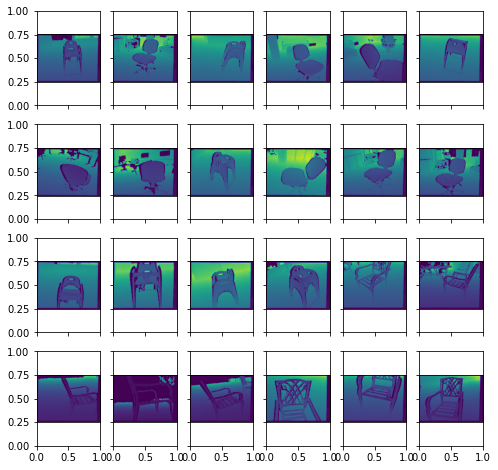

In [9]:
# test set 

#test_dataset = ImageDataset(root_dir='./data/kodac/', transform=transforms.Compose([RandomCrop(128), ToTensor()]))
test_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/test', transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()]))
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        if test_image.size(2)>test_image.size(3):
            test_image = test_image.permute(0, 1, 3, 2)
        
        reconstructed_image = model(test_image)
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
        plt.imshow(torch.squeeze(reconstructed_image.int().cpu()))

In [10]:
# save results
import cv2
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        reconstructed_image = model(test_image)
        reconstructed_depthmap = np.squeeze(reconstructed_image.cpu()).numpy()
        cv2.imwrite("D:\\autoencoder_data\\depthmaps2\\reconstructed\\beta_000001\\" + "img" + str(i)+".png", reconstructed_depthmap.astype(np.uint16))
        #save_image(reconstructed_depthmap, "D:\\autoencoder_data\\depthmaps\\reconstructed\\beta_0001\\" + "img" + str(i)+".png", normalize=True)

In [11]:
# compute PSNR for each image of the test set and its reconstruction

def write_data(filepath , tensor_data):
    batch, channel, h, w = tensor_data.size()
    matrix = tensor_data.cpu().numpy()
    file = open(filepath, "w")
    for image in range(batch):
        np.savetxt(file, matrix[image, :, :, :].reshape(channel*h, w), fmt ='%.0f')

    file.close()
    
def compute_entropy(tensor_data):
    min_val = tensor_data.min()
    max_val = tensor_data.max()
    nb_bins = max_val - min_val + 1
    hist = torch.histc(tensor_data, bins=nb_bins.int(), min=min_val, max=max_val)
    hist_prob = hist/hist.sum()
    hist_prob[hist_prob == 0] = 1
    entropy = -(hist_prob*torch.log2(hist_prob)).sum()
    return entropy
    
        
    
    
def psnr(original, compressed, max_pixel): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 


test_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/test', transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()]))
psnr_sum = 0.0
bit_rate_sum = 0.0
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, im_quantized] = model(test_image, 1, True)
        #write_data('.\\reconstructed_data\\kodac\\loss_distortion_and_bitrate\\beta_2\\latent_vect\\' + 'vec' + str(i) +'.txt', im_quantized)
        nb_symbols = im_quantized.size(0)*im_quantized.size(1)*im_quantized.size(2)*im_quantized.size(3)
        entropy = compute_entropy(im_quantized)
        nbpp = nb_symbols*entropy/float(test_image.size(0)*test_image.size(2)*test_image.size(3))
        psnr_sum+= psnr(test_image.cpu(), reconstructed_image.cpu(), 2**16-1.0)
        bit_rate_sum += nbpp
        print("entropy : ", entropy)
        print( "nb bits per pixel : ", nbpp)
        print("psnr : " , psnr(test_image.cpu(), reconstructed_image.cpu(), 2**16-1.0))
print( "mean nb bits per pixel : ", bit_rate_sum/len(test_dataset))
print("psnr mean : ", psnr_sum/len(test_dataset) )

entropy :  tensor(0.349899, device='cuda:0')
nb bits per pixel :  tensor(0.524849, device='cuda:0')
psnr :  tensor(59.187355)
entropy :  tensor(0.426014, device='cuda:0')
nb bits per pixel :  tensor(0.639022, device='cuda:0')
psnr :  tensor(55.545891)
entropy :  tensor(0.346363, device='cuda:0')
nb bits per pixel :  tensor(0.519545, device='cuda:0')
psnr :  tensor(61.006439)
entropy :  tensor(0.348571, device='cuda:0')
nb bits per pixel :  tensor(0.522856, device='cuda:0')
psnr :  tensor(56.008266)
entropy :  tensor(0.384229, device='cuda:0')
nb bits per pixel :  tensor(0.576343, device='cuda:0')
psnr :  tensor(55.692062)
entropy :  tensor(0.350737, device='cuda:0')
nb bits per pixel :  tensor(0.526105, device='cuda:0')
psnr :  tensor(60.428406)
entropy :  tensor(0.414963, device='cuda:0')
nb bits per pixel :  tensor(0.622444, device='cuda:0')
psnr :  tensor(55.716301)
entropy :  tensor(0.423974, device='cuda:0')
nb bits per pixel :  tensor(0.635961, device='cuda:0')
psnr :  tensor(53.

In [ ]:
def compute_entropy(tensor_data):
    min_val = tensor_data.min()
    max_val = tensor_data.max()
    nb_bins = max_val - min_val + 1
    hist = torch.histc(tensor_data, bins=nb_bins.int(), min=min_val, max=max_val)
    hist_prob = hist/hist.sum()
    hist_prob[hist_prob == 0] = 1
    entropy = -(hist_prob*torch.log2(hist_prob)).sum()
    return entropy
    
        
    
    
def psnr(original, compressed, max_pixel): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 


# Load previous model
model_prev = LossyCompAutoencoder()
model_prev.load_state_dict(torch.load('./model_parameters/lossy_comp_params_with_rate_beta2_incremental_2.pth'))
model_prev.eval()
model_prev.to(device)


# And run test 
test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, im_quantized] = model_prev(test_image,1, True)
        nb_symbols = im_quantized.size(0)*im_quantized.size(1)*im_quantized.size(2)*im_quantized.size(3)
        entropy = compute_entropy(im_quantized)
        nbpp = nb_symbols*entropy/float(test_image.size(0)*test_image.size(1)*test_image.size(2)*test_image.size(3))
        print("nb_symbols : ", nb_symbols)
        print("entropy : ", entropy)
        print( "nb bits per pixel : ", nbpp)
        print("psnr : " , psnr(test_image.cpu(), reconstructed_image.cpu(), 255.0))
    
# And print figures
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        if test_image.size(2)<test_image.size(3):
            test_image = test_image.permute(0, 1, 3, 2)
        
        reconstructed_image = model_prev(test_image, 1,  False)
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(reconstructed_image.int().cpu()).permute(1, 2, 0))
        
# And save figures
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        reconstructed_image = np.squeeze(model_prev(test_image).cpu())
        print(reconstructed_image.type())
        save_image(reconstructed_image, ".\\reconstructed_data\\kodac\\loss_distortion_and_bitrate\\beta_2_incremental_bis\\" + "img" + str(i)+".png", normalize=True)

In [ ]:
def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.01, 0.01).cuda()        
    gsm_sum = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm_sum_i = sum_gsm(x, var, phi, 6)
        gsm_sum[i] = gsm_sum_i

    entropy = torch.trapz(gsm_sum, u)
    
    return entropy


# Load incremental model
incremental_model = LossyCompAutoencoder()
incremental_model.load_state_dict(torch.load('./model_parameters/lossy_comp_params_with_rate_beta2_incremental.pth'))
incremental_model.eval()
incremental_model.to(device)

# train again the model starting form incremental-learned weights
    #define optimizer
optimizer = torch.optim.Adam(incremental_model.parameters(), lr=0.0001)

# define loss function
distortion = nn.MSELoss().cuda()


# define beta
beta = 2.0

#Epochs
n_epochs = 600


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
           
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized] = incremental_model(batch_images, False, True)
        optimizer.zero_grad()
        entropy = entropy_rate(x_quantized, incremental_model.phi, incremental_model.var)
        print("entropy : ", entropy)
        dist = distortion(decoded_images, batch_images)
        print("distortion : ", dist)
        loss = beta * dist + entropy
        loss.backward()
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )
    

In [ ]:
from range_coder import RangeEncoder, RangeDecoder, prob_to_cum_freq
import os

# Load previous model
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_params_with_rate_beta0005_incremental.pth'))
model.eval()
model.to(device)

nb_bits = 0.0
test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
with torch.no_grad():  
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, data_comp] = model(test_image, 1, True)
            # compute symbol probabilities
        min_val = data_comp.min()
        if min_val <0:
            data_comp -= min_val
            min_val = 0
        max_val = data_comp.max()
        nb_bins = max_val - min_val + 1
        hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
        prob = hist/hist.sum()
        #print("data comp : ", data_comp)
        #print(prob)
        
        """
        if len(torch.nonzero(prob)) != len(prob):
            zero_indices = ((prob == 0).nonzero())
            for j in reversed(range(0, len(zero_indices), 1)):
                data_comp[data_comp > int(zero_indices[j])+min_val] -=1
            min_val = data_comp.min()
            max_val = data_comp.max()
            nb_bins = max_val - min_val + 1
            hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
            prob = hist/hist.sum()
            print(min_val)
            print(max_val)
            print("data comp : ", data_comp)
            print(prob)
         """ 
            
            # convert probabilities to cumulative integer frequency table
        #cumFreq = prob_to_cum_freq(torch.clamp(prob, min=np.finfo(np.float32).eps).cpu(), resolution=128)
        cumFreq = prob_to_cum_freq(prob.cpu(), resolution=128)
        #print(cumFreq)
        
        # encode data
        filepath_to_write = "D:\\lossy_autoencoder\\latent_vect_encoded\\" + "img" + str(i) + ".bin"
        encoder = RangeEncoder(filepath_to_write)
        #print(torch.flatten(data_comp).cpu().tolist())
        encoder.encode(torch.flatten(data_comp.int()).cpu().tolist(), cumFreq)
        encoder.close()
        
        
        file_size = os.path.getsize(filepath_to_write)*8 #number of bits in the file
        print(file_size)
        nb_bits += file_size
        
    nb_bits_per_image = nb_bits/len(test_dataset)
    print(nb_bits_per_image)
    nb_bits_per_pixel = nb_bits_per_image/(512*768)
    print(nb_bits_per_pixel)
    
    
"""
    test_image = test_dataset[1].unsqueeze(0).to(device).float()
    [reconstructed_image, data_comp] = model(test_image, 1, True)
        # compute symbol probabilities
    min_val = data_comp.min()
    print(min_val)
    print(data_comp.max())
    if min_val <0:
        data_comp -= min_val
        min_val = 0
    max_val = data_comp.max()
    
    print(max_val)
    nb_bins = max_val - min_val + 1
    print(nb_bins)
    hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
    prob = hist/hist.sum()
    print(prob)
         # convert probabilities to cumulative integer frequency table
    cumFreq = prob_to_cum_freq(prob.cpu(), resolution=128)
    #print(cumFreq)

    print(torch.flatten(data_comp).cpu().tolist())
    
    
        # encode data
    filepath_to_write = "D:\\lossy_autoencoder\\latent_vect_encoded\\" + "img" + str(1) + ".bin"
    encoder = RangeEncoder(filepath_to_write)
    print(torch.flatten(data_comp).cpu().tolist())
    encoder.encode(torch.flatten(data_comp.int()).cpu().tolist(), cumFreq)
    encoder.close()   
""" 
    